<a href="https://colab.research.google.com/github/yexf308/MAT592/blob/main/9_SVM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is partially from https://github.com/tonio73/data-science. 

# Support Vector Machines 
### Perception revisited: linear separators 

perceptron is the composition of linear model and binary step function: (IN SVM section, we move the interception out and usually the class label is $\pm 1$)

$$\phi(\mathbf{w}^\top\mathbf{x}+w_0)=\begin{cases} 1 (\text{class 1})& \text{if }  \mathbf{w}^\top\mathbf{x}+w_0>0 \\   -1(\text{class -1}) & \text{otherwise}\end{cases} $$

This is a linear separator and only the sign of $\mathbf{w}^\top\mathbf{x}+w_0$ matters in making prediction. So the hyperplane $\mathbf{w}^\top\mathbf{x}+w_0=0$ is the **decision boundary**.

Given linearly separable data, the perceptron algorithm may converge to any of
the following solutions. These are all solutions to the optimization problem because at the global minimum 0, training data points only need to be on the
correct side of separating line. 




In [1]:
%pylab inline 
from IPython.display import Image


Image(url='https://github.com/yexf308/MAT592/blob/main/image/dec_bound.png?raw=true', width=600)

Populating the interactive namespace from numpy and matplotlib


## What is the best separator?
Most stable under perturbations of the inputs.

In [2]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/best_sep.png?raw=true', width=1000)

### Mathematical formulation of Hard Margin Classification

When we apply a threshold that gives us the largest margin (meaning that we are strict to ensure that no instances land within the margin) to make classifications this is called **Hard Margin Classification**. 

- Suppose the data points are separable by linear functions.
- Unit-length vector of the hyper-plane $\mathbf{w}^\top\mathbf{x}+w_0=0$ is $\mathbf{n}= \frac{\mathbf{w}}{\|\mathbf{w}\|}$. (plot it)

- since $\mathbf{w}^\top\mathbf{x}+w_0=0$ and $c(\mathbf{w}^\top\mathbf{x}+w_0)=0$ define the same plane, we will have the freedom to choose the norm of $\mathbf{w}$.   

-  Samples closest to the decision hyperplane are called **support vectors**. Without loss of generality, simply assume support vectors lie on hyperplanes $\mathbf{w}^\top\mathbf{x}+w_0=\pm 1$, called **margin boundary** 

In [3]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/svm.png?raw=true', width=600)

- Any sample $\mathbf{x}^{(i)}$ other than support vectors obeys $\mathbf{w}^\top\mathbf{x}+w_0>1$ or $\mathbf{w}^\top\mathbf{x}+w_0<-1$.

- Distance from any point $\mathbf{x}$ to the hyperplane separator $\mathbf{w}^\top\mathbf{x}+w_0=0$ is 
$$ r= \frac{|\mathbf{w}^\top\mathbf{x}+w_0|}{\|\mathbf{w}\|}$$

- Distance from support vectors to separator is defined as the margin $\rho=\frac{2}{\|\mathbf{w}\|}$. We want to maximize the margin. 

In [4]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/margin.png?raw=true', width=600)

Given linearly separable training set $\{\mathbf{x}^{(i)}, y^{(i)}\}\subset \mathbb{R}^d\times\{\pm 1\}$,
- **constraints**: for $\{\mathbf{x}^{(i)}, y^{(i)}\}$,  label is set so that $y^{(i)} = 1$ if $\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 \geq 1$, and $\mathbf{y}^{(i)} = -1$ if $\mathbf{w}^\top \mathbf{x} +w_0 \leq -1$. Uniformly,
$$
\mathbf{y}^{(i)}  (\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 )\geq 1, \; \forall \, i
$$

- find the max margin solution: 
$$\max_{\mathbf{w}, w_0} \rho:= \frac{2}{\|\mathbf{w}\|} \text{, subject to } \mathbf{y}^{(i)}  (\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 )\geq 1, \; \forall \, i
$$

or equivalently, 
$$\min_{\mathbf{w}, w_0} \frac{1}{2}\|\mathbf{w}\|_2^2 \text{, subject to } \mathbf{y}^{(i)}  (\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 )\geq 1, \; \forall \, i
$$

- It is quadratic programming: quadratic objective subject to linear constraints. It is a convex problem and there is unique global minimum. 

- This formulation can be solved using existing quadratic programming solvers such as CVXOPT and other methods. However, there is another formulation of the problem that can be solved without using quadratic programming techniques. 

- prediction: with the optimal parameters $(\mathbf{w}^*, w_0^*)$, one predicts $y= \text{sign}(\mathbf{w}^{*\top} \mathbf{x} +w_0^*)$



## Warning: Optimization!!!
Whiteboard derivation. 


We will instead implement a version of the Sequential Minimal Optimization (SMO) algorithm as described by John Platt to solve our optimization problem. This is much more involved. Try to follow it if you can.



In [5]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.colors as pltcolors
from scipy import optimize
import seaborn as sns

In [6]:
#some toy data generated by scikit-learn's
X_train, y = make_blobs(n_samples=500, centers=2,
                        n_features=2, random_state=1)
# We'll also scale the data to be centered at the origin with a unit standard deviation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
# we have to change the class labels to be +1 and -1 instead of 0 and 1.
y[y == 0] = -1

colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2


In [7]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-2, 2], [-2, 2]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
        #    ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

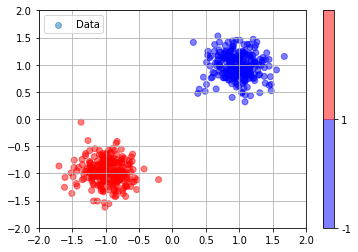

In [8]:
plotSvm(X_train_scaled, y)

In [9]:
class MaxMarginClassifier:
    
    def __init__(self):
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = -np.eye(N)
        b = np.zeros(N)
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP',  # Sequential Least Squares Programming
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Any support vector is at a distance of 1 to the separation plan
        # => use support vector #0 to compute the intercept, assume label is in {-1, 1}
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[0] - np.matmul(self.supportVectors[0].T, self.w)
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        activation = X.dot(self.w)+self.intercept
        return 2 * (activation>0) -1

In [10]:
model = MaxMarginClassifier()
model.fit(X_train_scaled, y)

In [11]:
print(model.w, model.intercept)
print(model.alpha[model.alpha>1e-6])
print(model.supportVectors)

[-0.96538284 -0.94732269] -0.1878402130255048
[0.91473836 0.59208901 0.32264935]
[[ 0.37796197  0.47215356]
 [-0.59635567 -0.64607875]
 [-0.8261318  -0.41187002]]


Number of support vectors = 3


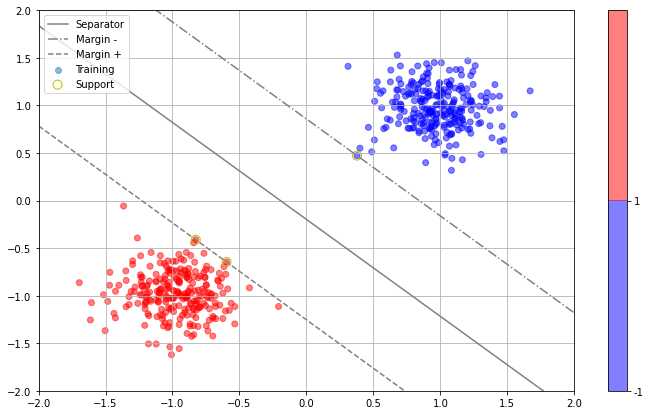

In [12]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(X_train_scaled, y, model.supportVectors, model.w, model.intercept, label='Training', ax=ax)

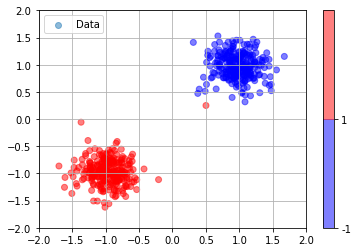

In [13]:
X_outlier = append(X_train_scaled, [0.5, 0.25])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = append(y, 1)
plotSvm(X_outlier, y_outlier)

In [14]:
model_outlier = MaxMarginClassifier()
model_outlier.fit(X_outlier, y_outlier)

Number of support vectors = 3


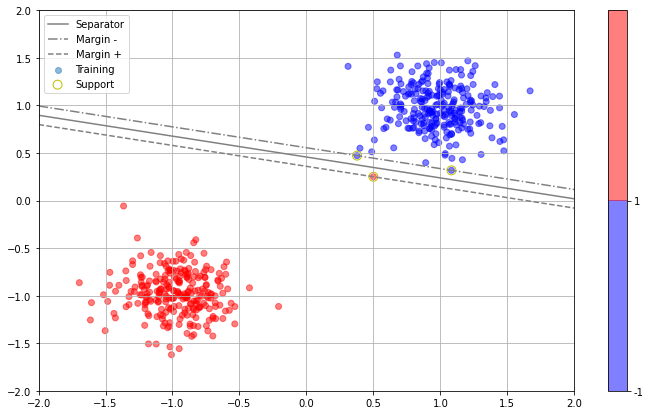

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(X_outlier, y_outlier, model_outlier.supportVectors, model_outlier.w, model_outlier.intercept, label='Training', ax=ax)

## What about regularization?
We can see above that a single outlier pushes the decision boundary much farther away from the rest of the population. We can eliminate this effect if we use a softer margin (a lower value for  $C$ ).



Now the outlier won't influence our decision boundary as much.



In [16]:
class SoftSvmClassifier:
    
    def __init__(self, C):
        self.C = C                                 # <---
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Support vectors is at a distance <= 1 to the separation plan
        # => use min support vector to compute the intercept, assume label is in {-1, 1}
        signedDist = np.matmul(self.supportVectors, self.w)
        minDistArg = np.argmin(signedDist)
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[minDistArg] - signedDist[minDistArg]
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        activation = X.dot(self.w)+self.intercept
        return 2 * (activation>0) -1

In [17]:
model1_soft = SoftSvmClassifier(C=1)
model1_soft.fit(X_outlier, y_outlier)
model1_soft.w, model1_soft.intercept

(array([-0.85531551, -0.98917138]), -0.11401337751540841)

Number of support vectors = 4


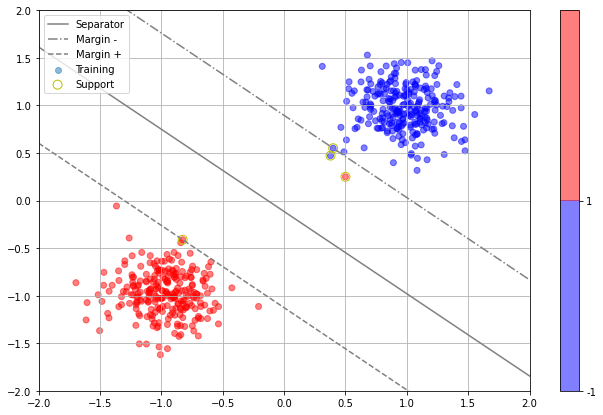

In [18]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(X_outlier, y_outlier, model1_soft.supportVectors, model1_soft.w, model1_soft.intercept, label='Training', ax=ax)

In [19]:
# validation 
X_test, y_test = make_blobs(n_samples=10000, centers=2,
                        n_features=2, random_state=1)
# We'll also scale the data to be centered at the origin with a unit standard deviation
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test, y_test)
y_test[y_test == 0] = -1


In [20]:
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');
                

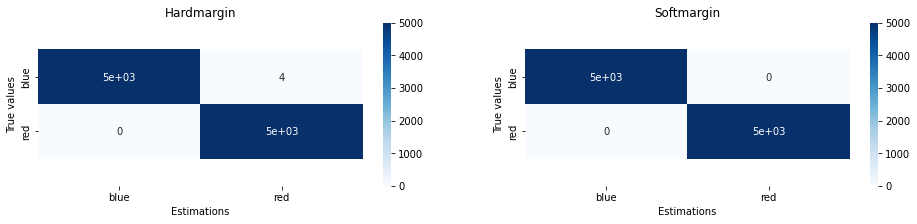

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
for model, ax, title in zip([model_outlier, model1_soft], axes, ['Hardmargin', 'Softmargin']):
    yEst = model.predict(X_test_scaled)
    plotConfusionMatrix(y_test, yEst, colors, title, ax=ax)

Number of support vectors = 3


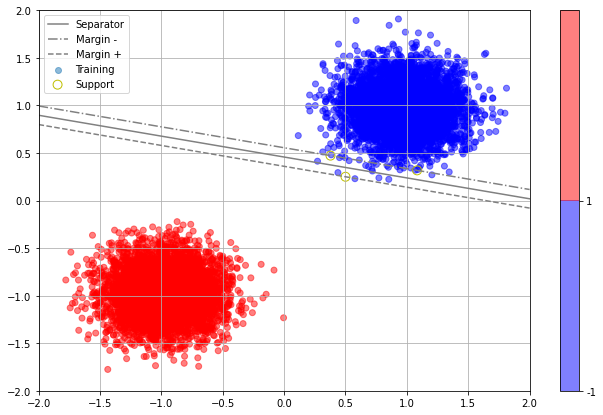

In [23]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(X_test_scaled, y_test, model_outlier.supportVectors, model_outlier.w, model_outlier.intercept, label='Training', ax=ax)